<a href="https://colab.research.google.com/github/smartgeometry-ucl/COMP0169-Machine-Learning-for-Visual-Computing-2021/blob/master/Week_2/Deep_Learning_for_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Imports

In [ ]:
# Lets import some libraries 
import torch # PyTorch 
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets # Datasets module 
from torchvision import transforms # Image Transforms 
from torchvision import models as pretrained_models # Pretrained models
import torch.nn.functional as F

import numpy as np
import cv2

from matplotlib import pyplot as plt
%matplotlib inline

##### Code to load custom image

In [ ]:
def load_custom_image(path):
    """
    Load image from path

    Return a Pytorch image tensor
    """

    img = cv2.imread(path)
    
    # BGR to RGB
    img = img[:, :, [2,1,0]]
    
    # Create a pytorch tensor from numpy
    img_pt = torch.from_numpy(img).float()
    
    # Add an extra 'batch' dimesion by unsqueeze
    # Convert the [B,H,W,3] image to [B,3,H,W]
    # These are necessary to feed image to pytorch networks
    img_pt = img_pt.unsqueeze(0).permute(0, 3, 1, 2)
    
    return img_pt

# Example 1
Classification

In [ ]:
def predict(test_loader, model, classes,scale=1):
    """
    This function will be used to predict using the trained neural network
    'model', and evaluate classification accuracy and show example images
    that are classified.

    Arguments:
    test_loader : Pytorch data loader. We iterate over this to obtain samples
    model : The neural network model object
    classes : The names of the classes
    """

    # Move model to GPU
    model = model.cuda()

    # No gradients, since we're evaluating and not training
    with torch.no_grad():
        model.eval()
        correct = 0

        # Iterate over the dataset
        for data, target in test_loader:
            # Data and its corresponding labels
            data, target = data.cuda(), target.cuda()
            
            # Predicted labels, using the model
            predictions = model(data)

            # Evaluate accuracy by comparing prediction to target
            predictions_index = predictions.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += predictions_index.eq(target.view_as(predictions_index)).long().cpu().sum()

    print('\nTest set accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # We have prediction indices, now print the label names using those 
    for p in predictions_index:
        print(classes[p])

    # Show some of the images.
    plt.figure()
    for i in range(data.size(0)):
        if data[i].size(0) == 3:
            pred = torch.unsqueeze(data[i].cpu(),0)
            resized = F.interpolate(pred,scale_factor=scale,mode='bicubic')
            plt.imshow(resized[0].permute(1,2,0))
        else:
            plt.imshow(data[i].permute(1,2,0).cpu().squeeze(), cmap='gray')
        plt.show()

#### MNIST example

In [ ]:
"""
Load the MNIST dataset. Pytorch has some datasets in the library, MNIST is one 
of them
"""

# Initialize the dataset. Apply transformation to each image
mnist_data = datasets.MNIST('../data', train=False, 
                    download=True, 
                    # The transform is applied to each image
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=[0.1307], std=[0.3081])
                   ])
                )

# Initializing the torch data loader using the dataset
mnist_test_loader = torch.utils.data.DataLoader(mnist_data,
                                          batch_size=5,
                                          shuffle=False)

# Class ids
classes = list(range(0,10))

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
"""
Pytorch has some pretrained neural network models. We're going to use 
a pretrained Alexnet to do some classification
"""

alexnet = pretrained_models.alexnet()
alexnet.features[0] = torch.nn.Conv2d(1,64, kernel_size=3)
alexnet.classifier[6] = torch.nn.Linear(4096,10)

# Get the trained weights, and load it into pytorch's Alexnet
!wget "http://geometry.cs.ucl.ac.uk/mlvc/week2_session_weights/mnist_net.pth" -O 'mnist_net.pth'
alexnet.load_state_dict(torch.load('mnist_net.pth'))

--2021-10-13 12:45:05--  http://geometry.cs.ucl.ac.uk/mlvc/week2_session_weights/mnist_net.pth
Resolving geometry.cs.ucl.ac.uk (geometry.cs.ucl.ac.uk)... 128.16.15.132
Connecting to geometry.cs.ucl.ac.uk (geometry.cs.ucl.ac.uk)|128.16.15.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228094655 (218M)
Saving to: ‘mnist_net.pth’

mnist_net.pth       100%[===================>] 217.53M  29.4MB/s    in 15s     

2021-10-13 12:45:21 (14.1 MB/s) - ‘mnist_net.pth’ saved [228094655/228094655]



<All keys matched successfully>


Test set accuracy: 9880/10000 (99%)

2
3
4
5
6


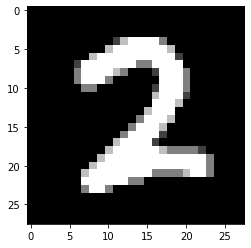

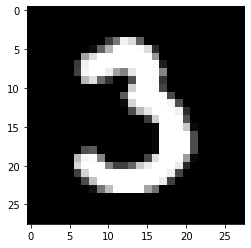

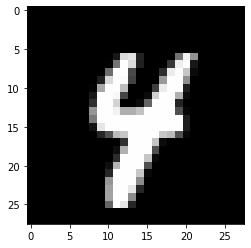

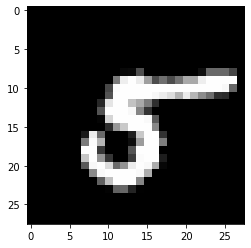

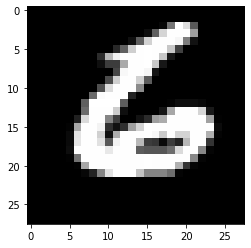

In [ ]:
# Predict on some MNIST Images using Alexnet
predict(mnist_test_loader, alexnet, classes)

#### CIFAR10 example



In [ ]:
"""
Now we'll test with CIFAR-10 dataset
"""

# Initialize the dataset. Apply transformation to each image
cifar_data = datasets.CIFAR10('../data', train=False, 
                    download=True,  
                    transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])
                   ])
)

# Initialize torch data loader using initialized dataset                
cifar_test_loader = torch.utils.data.DataLoader(cifar_data,
                                          batch_size=5,
                                          shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [ ]:
"""
Another pre-trained model available in Pytorch is VGG-16. We'll predict CIFAR-10 classes with that.
"""

vgg16 = pretrained_models.vgg16()
vgg16.classifier[6] = torch.nn.Linear(4096,10)

# Get and load pre-trained weights into pytorch's VGG-16
!wget "http://geometry.cs.ucl.ac.uk/mlvc/week2_session_weights/cifar10_net.pth" -O 'cifar10_net.pth'
vgg16.load_state_dict(torch.load('cifar10_net.pth'))

--2021-10-13 12:45:55--  http://geometry.cs.ucl.ac.uk/mlvc/week2_session_weights/cifar10_net.pth
Resolving geometry.cs.ucl.ac.uk (geometry.cs.ucl.ac.uk)... 128.16.15.132
Connecting to geometry.cs.ucl.ac.uk (geometry.cs.ucl.ac.uk)|128.16.15.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 537217935 (512M)
Saving to: ‘cifar10_net.pth’

cifar10_net.pth     100%[===================>] 512.33M  28.9MB/s    in 19s     

2021-10-13 12:46:14 (27.2 MB/s) - ‘cifar10_net.pth’ saved [537217935/537217935]



<All keys matched successfully>

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Test set accuracy: 8493/10000 (85%)

ship
cat
dog
car
horse


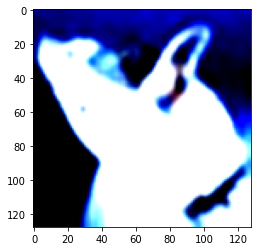

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


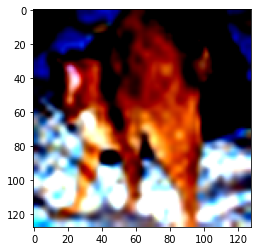

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


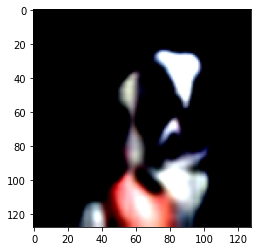

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


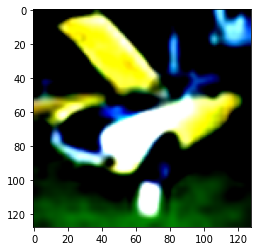

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


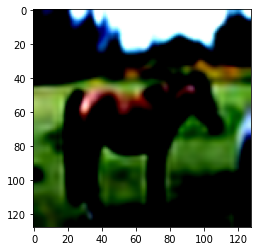

In [ ]:
# Predict CIFAR-10 classes using VGG-16
predict(cifar_test_loader, vgg16, classes,scale=4)

Check [HERE](https://pytorch.org/vision/stable/models.html#classification) to see what other model you can test

# HxWxC
# CxHxW

# BxCxHxW
# 5x3x32x32

# Example 2
Object detection

In [ ]:
"""
We use the COCO dataset, to test object detection.
"""

!wget http://images.cocodataset.org/zips/val2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip val2017.zip
!unzip annotations_trainval2017.zip

Output streaming troncato alle ultime 5000 righe.
 extracting: val2017/000000365745.jpg  
 extracting: val2017/000000320425.jpg  
 extracting: val2017/000000481404.jpg  
 extracting: val2017/000000314294.jpg  
 extracting: val2017/000000335328.jpg  
 extracting: val2017/000000513688.jpg  
 extracting: val2017/000000158548.jpg  
 extracting: val2017/000000132116.jpg  
 extracting: val2017/000000415238.jpg  
 extracting: val2017/000000321333.jpg  
 extracting: val2017/000000081738.jpg  
 extracting: val2017/000000577584.jpg  
 extracting: val2017/000000346905.jpg  
 extracting: val2017/000000433980.jpg  
 extracting: val2017/000000228144.jpg  
 extracting: val2017/000000041872.jpg  
 extracting: val2017/000000117492.jpg  
 extracting: val2017/000000368900.jpg  
 extracting: val2017/000000376900.jpg  
 extracting: val2017/000000352491.jpg  
 extracting: val2017/000000330790.jpg  
 extracting: val2017/000000384850.jpg  
 extracting: val2017/000000032735.jpg  
 extracting: val2017/000000197

In [ ]:
"""
Some bookkeeping code to map class ids to class names. Ignore this cell
"""

category_data = [{"supercategory": "person","id": 1,"name": "person"},{"supercategory": "vehicle","id": 2,"name": "bicycle"},{"supercategory": "vehicle","id": 3,"name": "car"},{"supercategory": "vehicle","id": 4,"name": "motorcycle"},{"supercategory": "vehicle","id": 5,"name": "airplane"},{"supercategory": "vehicle","id": 6,"name": "bus"},{"supercategory": "vehicle","id": 7,"name": "train"},{"supercategory": "vehicle","id": 8,"name": "truck"},{"supercategory": "vehicle","id": 9,"name": "boat"},{"supercategory": "outdoor","id": 10,"name": "traffic light"},{"supercategory": "outdoor","id": 11,"name": "fire hydrant"},{"supercategory": "outdoor","id": 13,"name": "stop sign"},{"supercategory": "outdoor","id": 14,"name": "parking meter"},{"supercategory": "outdoor","id": 15,"name": "bench"},{"supercategory": "animal","id": 16,"name": "bird"},{"supercategory": "animal","id": 17,"name": "cat"},{"supercategory": "animal","id": 18,"name": "dog"},{"supercategory": "animal","id": 19,"name": "horse"},{"supercategory": "animal","id": 20,"name": "sheep"},{"supercategory": "animal","id": 21,"name": "cow"},{"supercategory": "animal","id": 22,"name": "elephant"},{"supercategory": "animal","id": 23,"name": "bear"},{"supercategory": "animal","id": 24,"name": "zebra"},{"supercategory": "animal","id": 25,"name": "giraffe"},{"supercategory": "accessory","id": 27,"name": "backpack"},{"supercategory": "accessory","id": 28,"name": "umbrella"},{"supercategory": "accessory","id": 31,"name": "handbag"},{"supercategory": "accessory","id": 32,"name": "tie"},{"supercategory": "accessory","id": 33,"name": "suitcase"},{"supercategory": "sports","id": 34,"name": "frisbee"},{"supercategory": "sports","id": 35,"name": "skis"},{"supercategory": "sports","id": 36,"name": "snowboard"},{"supercategory": "sports","id": 37,"name": "sports ball"},{"supercategory": "sports","id": 38,"name": "kite"},{"supercategory": "sports","id": 39,"name": "baseball bat"},{"supercategory": "sports","id": 40,"name": "baseball glove"},{"supercategory": "sports","id": 41,"name": "skateboard"},{"supercategory": "sports","id": 42,"name": "surfboard"},{"supercategory": "sports","id": 43,"name": "tennis racket"},{"supercategory": "kitchen","id": 44,"name": "bottle"},{"supercategory": "kitchen","id": 46,"name": "wine glass"},{"supercategory": "kitchen","id": 47,"name": "cup"},{"supercategory": "kitchen","id": 48,"name": "fork"},{"supercategory": "kitchen","id": 49,"name": "knife"},{"supercategory": "kitchen","id": 50,"name": "spoon"},{"supercategory": "kitchen","id": 51,"name": "bowl"},{"supercategory": "food","id": 52,"name": "banana"},{"supercategory": "food","id": 53,"name": "apple"},{"supercategory": "food","id": 54,"name": "sandwich"},{"supercategory": "food","id": 55,"name": "orange"},{"supercategory": "food","id": 56,"name": "broccoli"},{"supercategory": "food","id": 57,"name": "carrot"},{"supercategory": "food","id": 58,"name": "hot dog"},{"supercategory": "food","id": 59,"name": "pizza"},{"supercategory": "food","id": 60,"name": "donut"},{"supercategory": "food","id": 61,"name": "cake"},{"supercategory": "furniture","id": 62,"name": "chair"},{"supercategory": "furniture","id": 63,"name": "couch"},{"supercategory": "furniture","id": 64,"name": "potted plant"},{"supercategory": "furniture","id": 65,"name": "bed"},{"supercategory": "furniture","id": 67,"name": "dining table"},{"supercategory": "furniture","id": 70,"name": "toilet"},{"supercategory": "electronic","id": 72,"name": "tv"},{"supercategory": "electronic","id": 73,"name": "laptop"},{"supercategory": "electronic","id": 74,"name": "mouse"},{"supercategory": "electronic","id": 75,"name": "remote"},{"supercategory": "electronic","id": 76,"name": "keyboard"},{"supercategory": "electronic","id": 77,"name": "cell phone"},{"supercategory": "appliance","id": 78,"name": "microwave"},{"supercategory": "appliance","id": 79,"name": "oven"},{"supercategory": "appliance","id": 80,"name": "toaster"},{"supercategory": "appliance","id": 81,"name": "sink"},{"supercategory": "appliance","id": 82,"name": "refrigerator"},{"supercategory": "indoor","id": 84,"name": "book"},{"supercategory": "indoor","id": 85,"name": "clock"},{"supercategory": "indoor","id": 86,"name": "vase"},{"supercategory": "indoor","id": 87,"name": "scissors"},{"supercategory": "indoor","id": 88,"name": "teddy bear"},{"supercategory": "indoor","id": 89,"name": "hair drier"},{"supercategory": "indoor","id": 90,"name": "toothbrush"}]

classid_to_name = {}


for data_dict in category_data:
  id_number = data_dict['id']
  name = data_dict['name']
  classid_to_name[id_number] = name

max_id = max(classid_to_name.keys())

In [ ]:
# Initialize Pytorch's CocoDetection dataset, apply transforms.
dataset_test = datasets.CocoDetection('./val2017','./annotations/instances_val2017.json', transform=transforms.Compose([transforms.ToTensor()]))

# Initialize dataloader with the dataset
data_loader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=1, shuffle=False, num_workers=4)


loading annotations into memory...
Done (t=0.59s)
creating index...
index created!


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
"""
Faster-RCNN is a deep-learning based object detection method.
It is available pre-trained from PyTorch
"""

# Initialize Faster-RCNN model
fasterRCNN = pretrained_models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
def detect_objects_in_image(model,image):
		"""
		Object detection using trained Faster-RCNN.

		Arguments:
		model : Trained Faster-RCNN model
		image : A pytorch tensor of shape [B,3,H,W] with pixels normalized to 0-1 range
		"""
		
		# Put the model in eval mode.
		model = model.eval()

		# Get the object detections on the image
		detections = model(image)[0]


		COLORS = np.random.uniform(0, 1, size=(max_id, 3))

		orig = image.squeeze().cpu().numpy().transpose(1,2,0).copy()

		# loop over the detections
		for i in range(0, len(detections["boxes"])):
			# extract the confidence (i.e., probability) associated with the
			# prediction
			confidence = detections["scores"][i]
			if confidence > 0.9:
				# filter out weak detections by ensuring the confidence is
				# greater than the minimum confidence
				# extract the index of the class label from the detections,
				# then compute the (x, y)-coordinates of the bounding box
				# for the object
				idx = int(detections["labels"][i])
				box = detections["boxes"][i].detach().cpu().numpy()
				(startX, startY, endX, endY) = box.astype("int")
				# display the prediction to our terminal
				label = "{}: {:.2f}%".format(classid_to_name[idx], confidence * 100)
				print("[INFO] {}".format(label))
				# draw the bounding box and label on the image
				cv2.rectangle(orig, (startX, startY), (endX, endY),
					COLORS[idx], 2)
				y = startY - 15 if startY - 15 > 15 else startY + 15
				cv2.putText(orig, label, (startX, y),
					cv2.FONT_HERSHEY_SIMPLEX, 0.5, COLORS[idx], 2)
			
		# show the output image
		plt.figure(figsize=(10,10))
		plt.imshow(orig)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[INFO] chair: 99.66%
[INFO] chair: 99.20%
[INFO] tv: 99.20%
[INFO] potted plant: 98.45%
[INFO] person: 98.38%
[INFO] clock: 96.86%
[INFO] vase: 95.73%
[INFO] vase: 95.71%
[INFO] dining table: 94.85%
[INFO] chair: 92.93%
[INFO] potted plant: 91.11%


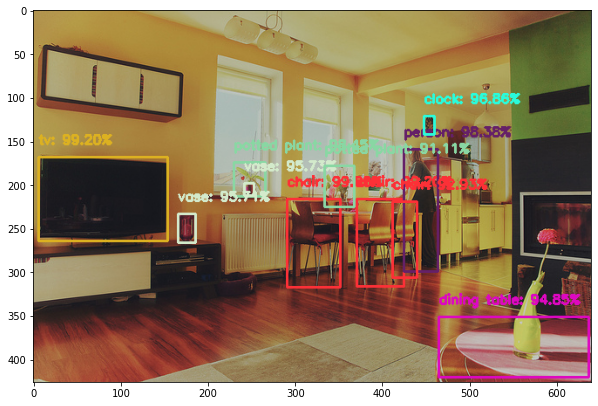

In [ ]:
# Get one Test image from the data loader. You can do multiple next operations, to get a different image.
image, labels = next(iter(data_loader_test))

# Move the image and the model to GPU
image = image.cuda()
model = fasterRCNN.cuda()

detect_objects_in_image(model,image)

--2021-10-13 10:24:58--  https://media-cdn.tripadvisor.com/media/photo-s/01/c0/38/f7/gower-street-one-way.jpg
Resolving media-cdn.tripadvisor.com (media-cdn.tripadvisor.com)... 23.12.192.210
Connecting to media-cdn.tripadvisor.com (media-cdn.tripadvisor.com)|23.12.192.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48838 (48K) [image/jpeg]
Saving to: ‘gower_street.jpg’

gower_street.jpg    100%[===================>]  47.69K  --.-KB/s    in 0.06s   

2021-10-13 10:24:59 (824 KB/s) - ‘gower_street.jpg’ saved [48838/48838]

[INFO] car: 99.89%
[INFO] person: 99.86%
[INFO] bicycle: 99.43%
[INFO] person: 99.16%
[INFO] car: 99.01%
[INFO] person: 98.96%
[INFO] person: 98.95%
[INFO] traffic light: 98.42%
[INFO] traffic light: 97.99%
[INFO] bus: 97.09%
[INFO] person: 91.54%


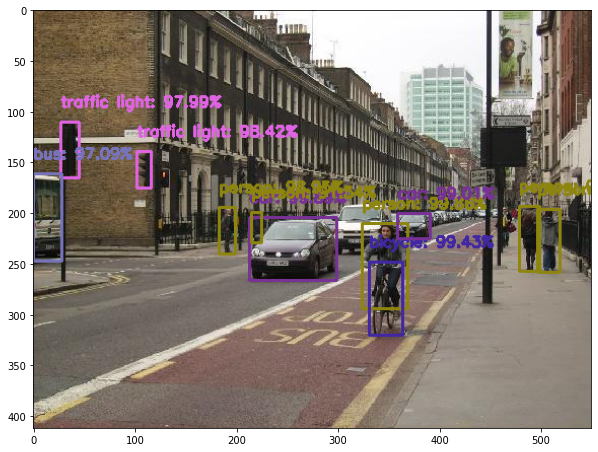

In [ ]:
# With a random image from the internet
!wget https://media-cdn.tripadvisor.com/media/photo-s/01/c0/38/f7/gower-street-one-way.jpg -O 'gower_street.jpg'
img = cv2.imread('gower_street.jpg')
img = img[:,:,[2,1,0]]
img = (img - np.min(img))/(np.max(img)-np.min(img))
image = torch.unsqueeze(torch.from_numpy(img),0).permute(0,3,1,2).float().cuda()

detect_objects_in_image(model,image)

# Example 3
Visualize NN activations pattern

In [ ]:
"""
We'll now visualize VGG's layer activations on an image.
"""

# Load pretrained VGG-16
vgg16 = pretrained_models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
def plot_image(img):
    """
    A utitlity function to normalize and display an image
    """
    
    img = img.detach().squeeze().permute(1,2,0)

    # mean and std list for channels (Imagenet)
    mean = torch.tensor([0.485, 0.456, 0.406]).float().reshape(1,1,3)
    std = torch.tensor([0.229, 0.224, 0.225]).float().reshape(1,1,3)

    img *= std
    img += mean
    img = torch.clamp(img, 0.0, 1.0)
    
    np_image = img.cpu().numpy()
    plt.figure()
    plt.imshow(np_image)
    plt.show()

In [ ]:
def visualize_cnn_filters(model, cnn_layer, selected_filter):
    """
    Visualize a single filter of a given layer of the network

    Arguments:
    model : The neural network model
    cnn_layer : Layer number inside this network
    selected_filter : Filter number in the layer
    """

    model.eval()
    model = model.cuda()

    # Generate a random image
    random_image = torch.rand([1,3,224,224])
    random_image = Variable(random_image, requires_grad=True)

    # Define optimizer for the image
    optimizer = Adam([random_image], lr=0.1, weight_decay=1e-6)

    for i in range(1, 100):

        optimizer.zero_grad()
    
        # Assign create image to a variable to move forward in the model
        x = random_image.cuda()
    
        for index, layer in enumerate(model):
            # Forward pass layer by layer
            # x is not used after this point because it is only needed to trigger
            # the forward hook function
            x = layer(x)
            # Only need to forward until the selected layer is reached
            if index == cnn_layer:
                # (forward hook function triggered)
                break

        filter_output = x[0, selected_filter]

        # Loss function is the mean of the output of the selected layer/filter
        # We try to minimize the mean of the output of that specific filter
        loss = -torch.mean(filter_output)
        
        # Backward - propagate the loss through the layers up to the input image
        loss.backward()
        
        # Update the input image based on computed gradients
        optimizer.step()
    

    plot_image(random_image)

In [ ]:
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

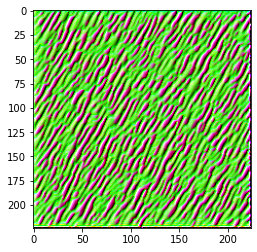

In [ ]:
cnn_layer = 2
filter_pos = 5
visualize_cnn_filters(vgg16.features, cnn_layer, filter_pos)

What are patterns are recognized by other filter ? Try to change the 'cnn_layer' and 'filter_pos' variable below.

# Example 4
Visualize which piece of image activates neurons

In [ ]:
"""
Get some image from the internet, load it locally
"""

!wget https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png 'spider.png'

--2021-10-13 10:30:31--  https://raw.githubusercontent.com/utkuozbulak/pytorch-cnn-visualizations/master/input_images/spider.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52339 (51K) [image/png]
Saving to: ‘spider.png’

spider.png          100%[===================>]  51.11K  --.-KB/s    in 0.03s   

2021-10-13 10:30:32 (1.99 MB/s) - ‘spider.png’ saved [52339/52339]

--2021-10-13 10:30:32--  http://spider.png/
Resolving spider.png (spider.png)... failed: Name or service not known.
wget: unable to resolve host address ‘spider.png’
FINISHED --2021-10-13 10:30:32--
Total wall clock time: 0.2s
Downloaded: 1 files, 51K in 0.03s (1.99 MB/s)


In [ ]:
# Load the image as a pytorch tensor
image = load_custom_image('spider.png')

In [ ]:
def visualize_cnn_filters(model, input_image, cnn_layer):
    """
    Find out which parts of the image activate a particular filter in a given layer of the network

    Arguments:
    model : The neural network model
    input_image : The input image to test on
    cnn_layer : A layer number into the network
    """

    model.eval()
    model = model.cuda()
    input_image = input_image.cuda()

    model.zero_grad()
    # Forward pass
    x = input_image
    for index, layer in enumerate(model.features):
        # Forward pass layer by layer
        # x is not used after this point because it is only needed to trigger
        # the forward hook function
        x = layer(x)
        # Only need to forward until the selected layer is reached
        if index == cnn_layer:
            # (forward hook function triggered)
            break


    scale = input_image.size(-1)/x.size(-1)

    # We upsample the filter activation to the image size, so we can overlay the activation
    # on top of the image, to see which part of the image contributed to the activation
    return torch.nn.functional.upsample(x, scale_factor=scale, mode='bilinear')[0, filter_pos].detach().cpu().numpy()


In [ ]:
vgg16 = pretrained_models.vgg16(pretrained=True)

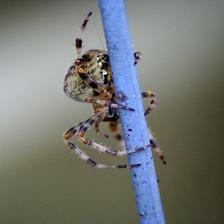

In [ ]:
# Display original image
from IPython.display import Image
Image('spider.png')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3487: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


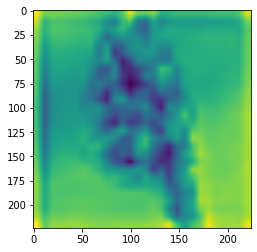

In [ ]:
# Play around with cnn_layer and filter_pos
cnn_layer = 17

activations = visualize_cnn_filters(vgg16, image.cuda(), cnn_layer)

plt.figure()
plt.imshow(activations)
plt.show()
